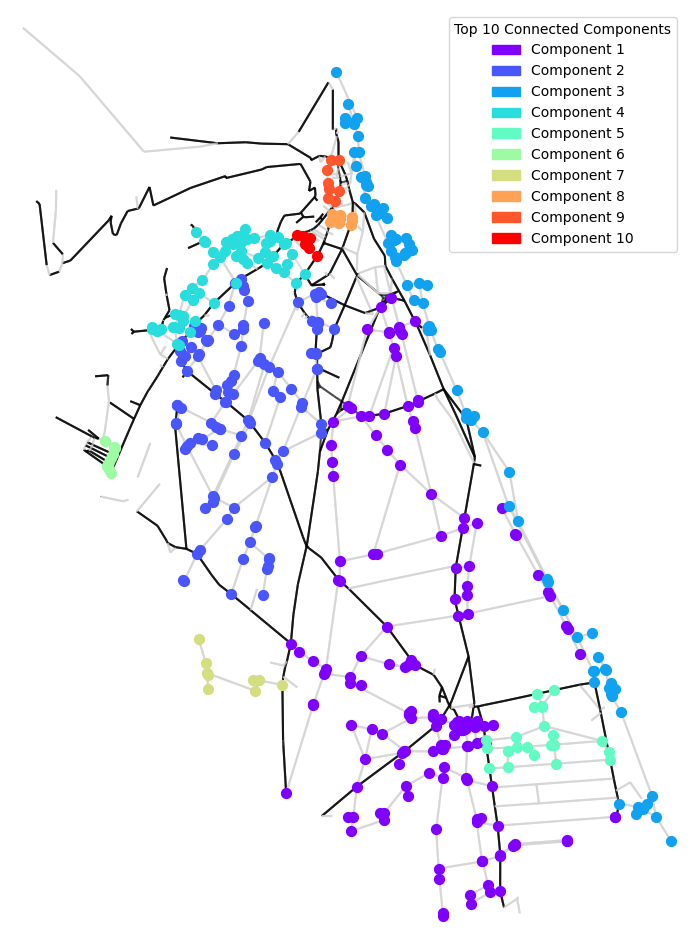

Connected Component 1: {912304642, 912307214, 1875944468, 3445307415, 375694362, 3506974251, 3481947692, 3445307439, 4537840691, 1875944507, 3506974267, 4537840705, 4187438666, 912311372, 3824639566, 4187438672, 3824639579, 4187439196, 4187439199, 1894585954, 375694438, 912302191, 3545182320, 1894585978, 3741330043, 1894585980, 3824639613, 3445307007, 3445307011, 375694984, 912283274, 2143843981, 3824639630, 2143843984, 3824639635, 375694484, 4230598295, 4230598296, 3824639642, 3445307035, 1894586012, 1894586014, 4230598315, 2078574764, 375694512, 3824639672, 912302776, 4230598338, 3783680709, 3680118469, 4230598358, 737610454, 2143871193, 3506974430, 2078574818, 3481946852, 4230598374, 912306922, 3723637997, 3723638012, 912287486, 3506974464, 3506974467, 912305927, 912295190, 3506974487, 912298271, 912306982, 6684814128, 3506974512, 1946089778, 3506974525, 912310593, 1946089796, 3783691600, 2980754259, 3506974548, 3506974552, 6684814180, 1946089828, 912286567, 1946089831, 481334637, 3

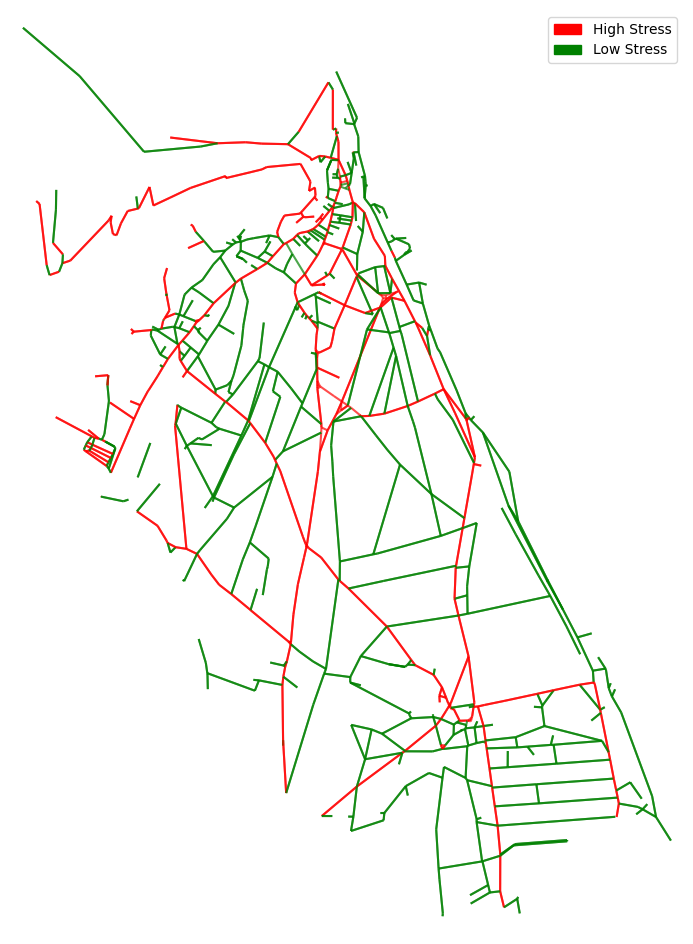

In [2]:
import osmnx as ox
import networkx as nx
from shapely.geometry import Point
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import collections
import matplotlib.patches as mpatches
import matplotlib.cm as cm

# Load data
filepath = "/Users/leonardo/Desktop/Tesi/LTSBikePlan/data/Montereale_Valcellina_lts.graphml"
G_lts = ox.load_graphml(filepath)
G_lts = ox.project_graph(G_lts, to_crs='EPSG:4326')

# 1. Filter the Graph
low_stress_edges = [(u, v, k, data) for u, v, k, data in G_lts.edges(keys=True, data=True) if 'lts' in data and data['lts'] in ['1', '2']]
low_stress_nodes = [node for node, data in G_lts.nodes(data=True) if 'lts' in data and data['lts'] in ['1', '2']]

# Create a new graph with only low-stress edges and nodes
G_low_stress = nx.MultiDiGraph()
G_low_stress.add_nodes_from(low_stress_nodes)
G_low_stress.add_edges_from(low_stress_edges)

# 2. Find Connected Components
# Convert the graph to undirected for finding connected components
G_low_stress_undirected = G_low_stress.to_undirected()
connected_components = list(nx.connected_components(G_low_stress_undirected))

# Sort the connected components by size (largest to smallest) and select the top 10
top_components = sorted(connected_components, key=len, reverse=True)[:10]

# Assign a unique color to each of the top 10 connected components
colors = cm.rainbow(np.linspace(0, 1, len(top_components)))
component_colors = {}
component_patches = [] 
for color, component in zip(colors, top_components):
    for node in component:
        component_colors[node] = color
    component_patches.append(mpatches.Patch(color=color, label=f'Component {len(component_patches) + 1}'))

# Visualization
fig, ax = plt.subplots(figsize=(12, 12))

# Get node positions using osmnx
node_positions = {node: (data['x'], data['y']) for node, data in G_lts.nodes(data=True)}

# Plot edges with their respective colors
edge_colors = ['black' if ('lts' in data and data['lts'] in ['3', '4']) else 'lightgray' for u, v, k, data in G_lts.edges(keys=True, data=True)]
ox.plot_graph(G_lts, ax=ax, node_size=0, edge_color=edge_colors, edge_linewidth=1.5, edge_alpha=0.7, show=False)

# Highlight the top 10 connected components with unique colors
for node, color in component_colors.items():
    nx.draw_networkx_nodes(G_lts, pos=node_positions, nodelist=[node], node_color=[color], node_size=50, ax=ax)

# Add legend for the top 10 connected components
ax.legend(handles=component_patches, loc='upper right', title='Top 10 Connected Components')

plt.show()

# 3. Identify Gaps
# Print the gaps between connected components
for i, component in enumerate(connected_components[:10]):
    print(f"Connected Component {i+1}: {component}")

# Optionally, visualize the graph
fig, ax = plt.subplots(figsize=(12, 12))
colors = ['red' if ('lts' in data and data['lts'] in ['3', '4']) else 'green' for u, v, k, data in G_lts.edges(keys=True, data=True)]
ox.plot_graph(G_lts, ax=ax, node_size=0, edge_color=colors, edge_linewidth=1.5, edge_alpha=0.7, show=False)

# Add legend to the same plot
red_patch = mpatches.Patch(color='red', label='High Stress')
green_patch = mpatches.Patch(color='green', label='Low Stress')
ax.legend(handles=[red_patch, green_patch], loc='upper right')

plt.show()

In [3]:
## IDCP procedure - Identify

# 1. Identify Contact Nodes
contact_nodes = []
for node, data in G_lts.nodes(data=True):
    adjacent_edges = list(G_lts.out_edges(node, data=True))
    lts_values = [data['lts'] for _, _, data in adjacent_edges]
    if ('1' in lts_values or '2' in lts_values) and ('3' in lts_values or '4' in lts_values):
        contact_nodes.append(node)

# 2. Identify High-Stress Paths using Dijkstra all-pair shortest path algorithm
high_stress_paths = {}
for source in contact_nodes:
    lengths, paths = nx.single_source_dijkstra(G_lts, source, weight='length')
    for target, path in paths.items():
        if target in contact_nodes and source != target:
            lts_values = [G_lts[path[i]][path[i+1]][0]['lts'] for i in range(len(path)-1)]
            if all(lts in ['3', '4'] for lts in lts_values):
                high_stress_paths[(source, target)] = path

# 3. Filter Shortest High-Stress Paths
shortest_high_stress_paths = {}
for (source, target), path in high_stress_paths.items():
    if (target, source) not in shortest_high_stress_paths:
        if (target, source) in high_stress_paths:
            if len(path) < len(high_stress_paths[(target, source)]):
                shortest_high_stress_paths[(source, target)] = path
        else:
            shortest_high_stress_paths[(source, target)] = path

# Print the shortest high-stress paths
# for (source, target), path in shortest_high_stress_paths.items():
#     print(f"Gap from {source} to {target}: {path}")

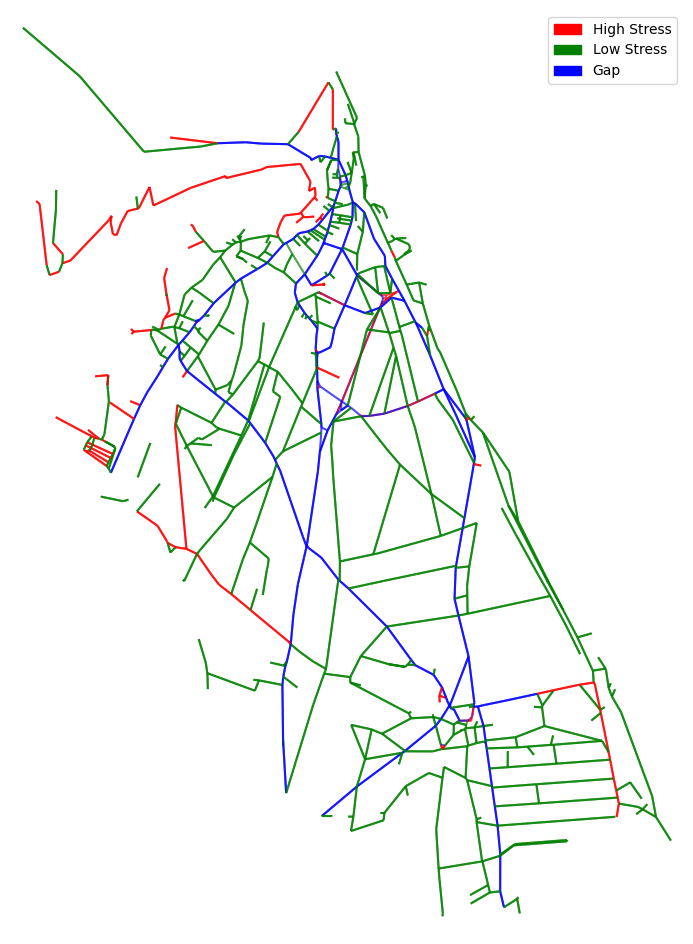

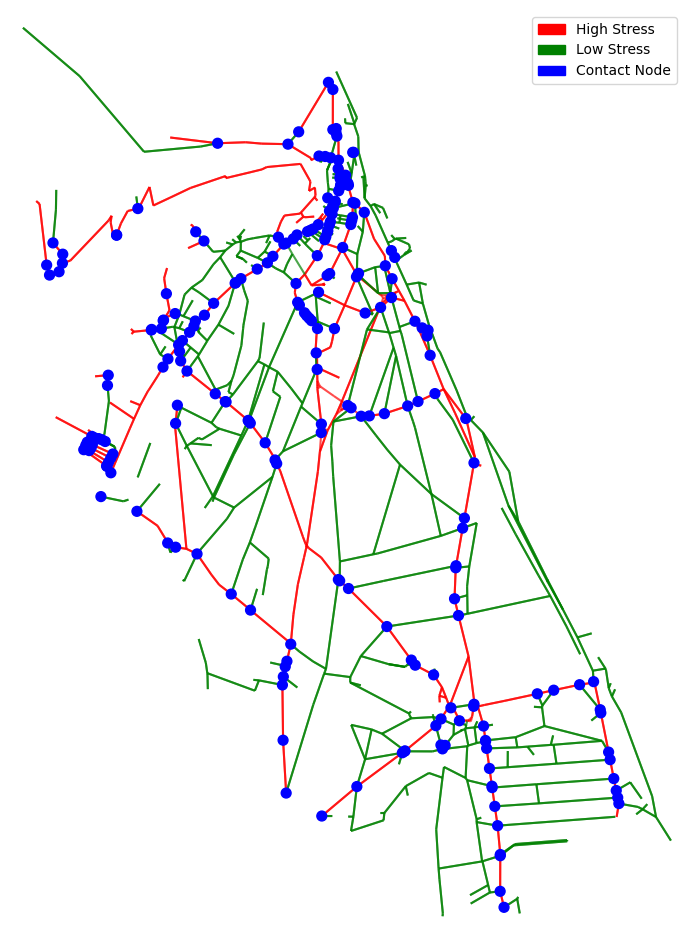

In [4]:
# Visualization edges and gaps contact nodes

# Create a list of edge colors for the entire graph
edge_colors = []
for u, v, k, data in G_lts.edges(keys=True, data=True):
    if 'lts' in data:
        if data['lts'] in ['1', '2']:
            edge_colors.append('green')
        elif data['lts'] in ['3', '4']:
            edge_colors.append('red')
        else:
            edge_colors.append('gray')
    else:
        edge_colors.append('gray')

# Highlight the gaps in blue
all_edges = list(G_lts.edges(keys=True))
for (source, target), path in shortest_high_stress_paths.items():
    for i in range(len(path) - 1):
        edge_tuple = (path[i], path[i+1], 0)
        edge_index = all_edges.index(edge_tuple)
        edge_colors[edge_index] = 'blue'

# Plot the graph with highlighted gaps
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(G_lts, ax=ax, node_size=0, edge_color=edge_colors, edge_linewidth=1.5, edge_alpha=0.7, show=False)

# Add legend to the same plot
red_patch = mpatches.Patch(color='red', label='High Stress')
green_patch = mpatches.Patch(color='green', label='Low Stress')
blue_patch = mpatches.Patch(color='blue', label='Gap')
ax.legend(handles=[red_patch, green_patch, blue_patch], loc='upper right')

plt.show()

# Visualization
fig, ax = plt.subplots(figsize=(12, 12))

# Get node positions using osmnx
node_positions = {node: (data['x'], data['y']) for node, data in G_lts.nodes(data=True)}

# Plot edges with their respective colors
colors = ['red' if ('lts' in data and data['lts'] in ['3', '4']) else 'green' for u, v, k, data in G_lts.edges(keys=True, data=True)]
ox.plot_graph(G_lts, ax=ax, node_size=0, edge_color=colors, edge_linewidth=1.5, edge_alpha=0.7, show=False)

# Highlight contact nodes
contact_node_colors = {node: 'blue' for node in contact_nodes}
nx.draw_networkx_nodes(G_lts, pos=node_positions, nodelist=contact_node_colors.keys(), node_color=list(contact_node_colors.values()), node_size=50, ax=ax)

# Add legend to the same plot
red_patch = mpatches.Patch(color='red', label='High Stress')
green_patch = mpatches.Patch(color='green', label='Low Stress')
blue_patch = mpatches.Patch(color='blue', label='Contact Node')
ax.legend(handles=[red_patch, green_patch, blue_patch], loc='upper right')

plt.show()


In [5]:
# Assuming you have already run the previous code blocks

# 4. Calculate Detour Factor and Filter Gaps
D_min = 1.5
filtered_gaps = {}

for (source, target), high_stress_path in shortest_high_stress_paths.items():
    # Calculate the shortest path distance on the low stress network (d_prot(g))
    try:
        d_lowstress_g = nx.shortest_path_length(G_low_stress, source=source, target=target, weight='length')
    except nx.NetworkXNoPath:
        # If there's no path in the low stress network, we can't calculate a detour factor
        continue
    
    # Calculate the shortest path distance on the entire street network (d_all(g))
    d_all_g = nx.shortest_path_length(G_lts, source=source, target=target, weight='length')
    
    # Calculate the detour factor (D(g))
    D_g = d_lowstress_g / d_all_g
    
    # Filter gaps with D(g) less than D_min
    if D_g >= D_min:
        filtered_gaps[(source, target)] = high_stress_path

#Print the filtered gaps
for (source, target), path in filtered_gaps.items():
    print(f"Filtered Gap from {source} to {target}: {path}")


Filtered Gap from 295257285 to 912309569: [295257285, 3741329882, 275047789, 1812888011, 3741329912, 3741330034, 1875944435, 2853275099, 4703791335, 3723637983, 4230598077, 5808412702, 912297744, 665371476, 912310417, 912282927, 2142860777, 295279410, 912294506, 912305093, 912294645, 912309569]
Filtered Gap from 1902148479 to 912300252: [1902148479, 912295544, 912296850, 6532722874, 912303265, 275047641, 6532857567, 912298815, 912300252]
Filtered Gap from 318694337 to 3723638160: [318694337, 3868226372, 912289180, 2980754259, 912306120, 2078574772, 1946089897, 912308859, 912298311, 912288978, 3481946852, 912283001, 3723638160]
Filtered Gap from 2143843981 to 3723638160: [2143843981, 318694337, 3868226372, 912289180, 2980754259, 912306120, 2078574772, 1946089897, 912308859, 912298311, 912288978, 3481946852, 912283001, 3723638160]
Filtered Gap from 912287486 to 3723638160: [912287486, 912311207, 2078574776, 912298004, 2078574783, 2143843981, 318694337, 3868226372, 912289180, 2980754259, 

The positive impact consists in reducing the number of meters that cyclists have to ride in the same space as motorized traffic, so with high stress.  Therefore, the aim is to prioritizing gaps that lie on the most commonly taken bicycle routes.

To prioritize these gaps, the authors suggest considering three main questions:
- Centrality: How central is the missing link in the network?
- Cost: How much does it cost to close this gap?
- Benefit: How many citizens will benefit from closing it? (The "benefit" of closing a gap is quantified by the reduction in the number of meters that cyclists have to ride in mixed traffic with motorized vehicles)
  
To estimate the most commonly used bicycle routes (and thus identify the most important gaps), the authors of IDPC use a metric called **"link betweenness centrality weighted by gap length."** This metric is based on the assumption that cyclists will choose the shortest path between their origin and destination. The betweenness centrality of a link in the network indicates how often that link is used in the shortest paths between all pairs of nodes in the network. By weighting this centrality by the length of the gap, they can estimate the total number of meters cycled in mixed traffic for each gap.

*In order to apply this rationale, we estimated the number of cyclists on each link, i.e. the bicycle traffic flow through the network, based on the network topology, using betweenness centrality. Betweenness centrality, derived from an all-pair shortest path algorithm, is the most basic proxy for traffic demand. It assumes that for each possible origin-destination combination, there is one “cyclist unit” making their way through the network, always choosing the shortest possible path between origin and destination. Then the number of cyclists that use a specific link on their way through the network, divided by the total number of cyclists on the network, will yield the fraction of cyclists that we expect to find on this link. Thus, the betweenness centrality indicates how “central” or relevant a link is for the flow of cyclists through the whole network*

The authors also introduce a locality parameter (𝜆) to account for the **"network edge effect"**, which biases centrality metrics towards the center of the network. By setting 𝜆 to a finite value (2500m in their case for Copenhagen district diameter), they can focus on gaps that are relevant for local flows within neighborhoods or districts, rather than the entire city.

Finally, they calculate a **"gap closure benefit" (B*(g))** for each gap, which is the product of the betweenness centrality and the length of the gap. This metric represents the total number of expected meters cycled on the gap. They then divide this by the total length of the gap to get a measure of the expected meters cycled per investment unit (B(g)), which they use to prioritize gaps for closure.

Gap from 1902148479 to 912300252: Benefit Metric = 12.7224025974026
Gap from 912309569 to 665371492: Benefit Metric = 9.758928571428571
Gap from 2142859863 to 665371492: Benefit Metric = 9.002435064935066
Gap from 3855089606 to 665371492: Benefit Metric = 8.942370129870131
Gap from 3751714174 to 665371492: Benefit Metric = 8.942370129870131
Gap from 3855091957 to 665371492: Benefit Metric = 8.93262987012987
Gap from 665371492 to 3481947867: Benefit Metric = 7.424512987012987
Gap from 665371492 to 2197350694: Benefit Metric = 7.325487012987012
Gap from 665371492 to 564874543: Benefit Metric = 6.559253246753246
Gap from 665371492 to 2142857630: Benefit Metric = 6.546266233766233
Gap from 665371492 to 2142857636: Benefit Metric = 6.512175324675324
Gap from 665371492 to 4703791323: Benefit Metric = 6.495941558441559
Gap from 665371492 to 564874513: Benefit Metric = 6.4894480519480515
Gap from 912309569 to 564874449: Benefit Metric = 6.237824675324676
Gap from 912309569 to 3751713975: Benef

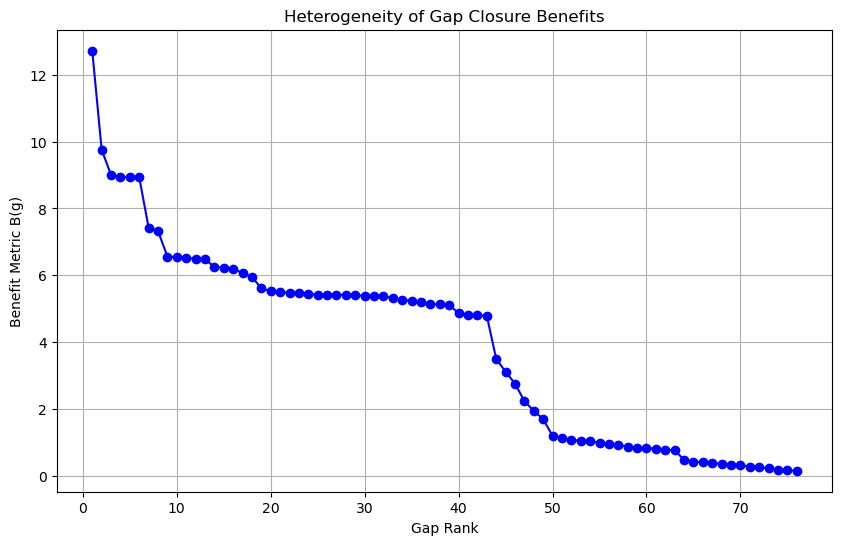

In [6]:
## IDCP procedure - Prioritize

# 5. Calculate Betweenness Centrality with Locality Parameter λ
lambda_ = 1000  # Set the locality parameter lambda (𝜆) to 2500 meters

# Custom function to compute betweenness centrality with locality parameter λ
def localized_betweenness_centrality(G, lambda_, weight='length'):
    node_local_betweenness = collections.defaultdict(int)
    for node in G.nodes():
        # Compute all shortest paths from the node within the locality parameter λ
        lengths, paths = nx.single_source_dijkstra(G, node, cutoff=lambda_, weight=weight)
        for target, path in paths.items():
            if target != node:  # Exclude the node itself
                for path_node in path[1:-1]:  # Exclude the source and target nodes
                    node_local_betweenness[path_node] += 1
    
    # Normalize the betweenness centrality values (big cities)
    # norm_factor = 1 / ((len(G.nodes()) - 1) * (len(G.nodes()) - 2))
    # node_local_betweenness = {node: value * norm_factor for node, value in node_local_betweenness.items()}

    # Normalize the betweenness centrality values (town/village scenario)
    norm_factor = 1 / (len(G.nodes()) - 1)
    node_local_betweenness = {node: value * norm_factor for node, value in node_local_betweenness.items()}

    return node_local_betweenness

# Compute betweenness centrality for all nodes in the network with locality parameter λ
node_betweenness = localized_betweenness_centrality(G_lts, lambda_, weight='length')

# 6. Estimate Bicycle Traffic Flow and Compute Benefit Metric with Cost-Efficiency
gap_closure_benefits = {}

for (source, target), path in filtered_gaps.items():
    # Total length of the gap (L(g))
    L_g = sum(G_lts[path[i]][path[i+1]][0]['length'] for i in range(len(path)-1))
    
    # Betweenness centrality for the gap (c_lambda(l))
    c_lambda_l = sum(node_betweenness.get(node, 0) for node in path)  # Use .get() to handle missing nodes
    
    # Total number of expected meters cycled on this gap (B*(l))
    B_star_l = c_lambda_l * L_g
    
    # Expected meters cycled per investment unit (B(g)), accounting for cost-efficiency
    B_g = B_star_l / L_g if L_g > 0 else 0
    
    # Store the benefit metric for each gap
    gap_closure_benefits[(source, target)] = B_g

# Sort the gaps by their benefit metric in descending order
sorted_gaps_by_benefit = sorted(gap_closure_benefits.items(), key=lambda item: item[1], reverse=True)

# Print the sorted gaps with their benefit metric
for (source, target), benefit in sorted_gaps_by_benefit:
    print(f"Gap from {source} to {target}: Benefit Metric = {benefit}")

# Extract the benefit metrics from the sorted list
benefits = [benefit for (source, target), benefit in sorted_gaps_by_benefit]

# Create a rank for each gap based on its position in the sorted list
ranks = range(1, len(benefits) + 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(ranks, benefits, marker='o', linestyle='-', color='b')
plt.title('Heterogeneity of Gap Closure Benefits')
plt.xlabel('Gap Rank')
plt.ylabel('Benefit Metric B(g)')
plt.grid(True)
plt.show()


To implement the declustering step I need to:

1. Filter out the gaps with a benefit metric \( B(g) \) below a certain cutoff threshold \( B(g)_{min} \).
2. Create a network from the remaining gaps.
3. Decompose the network into disconnected components.
4. For each disconnected component, while it is not empty, do the following:
   - Compute all shortest paths between the nodes in the component.
   - Calculate the benefit metric for each path.
   - Find the path with the highest benefit metric and add it to the final gap list.
   - Remove the path from the component.
5. From the final gap list, remove the gaps with a benefit metric below the cutoff threshold \( B(g)_{min} \) again.

In [42]:
## IDCP procedure - Declustering

# Count the number of gaps before declustering
num_gaps_before = len(filtered_gaps)
print(f"Number of gaps before declustering: {num_gaps_before}")

# Assuming B_g_min is the cut-off benefit metric value
B_g_min = 7  # Example threshold value
print(f"Cut-off benefit metric (B_g_min): {B_g_min}")

# Step 1: Filter out gaps with B(g) less than B_g_min
gaps_above_threshold = {k: v for k, v in gap_closure_benefits.items() if v >= B_g_min}
print(f"Number of gaps above threshold: {len(gaps_above_threshold)}")

# Step 2: Create a network/graph from the remaining gaps
G_network = nx.Graph()
for (source, target), path in filtered_gaps.items():
    if (source, target) in gaps_above_threshold:
        # Add edges to the graph for each path segment
        G_network.add_edges_from(zip(path[:-1], path[1:]))

print(f"Number of nodes in G_network: {G_network.number_of_nodes()}")
print(f"Number of edges in G_network: {G_network.number_of_edges()}")

# Step 3: Decompose the network into disconnected components
disconnected_components = list(nx.connected_components(G_network))
print(f"Number of disconnected components: {len(disconnected_components)}")

# List to hold the final non-overlapping gaps
final_gap_list = []

# Step 4: Process each component
for component in disconnected_components:
    comp_graph = G_network.subgraph(component).copy()

    while comp_graph.number_of_edges() > 0:
        # Compute all shortest paths in the component graph
        all_paths = nx.shortest_path(comp_graph)

        # Calculate benefit metric B(g) for each path
        path_benefits = {}
        for source, paths in all_paths.items():
            for target, path in paths.items():
                if source != target and (source, target) in filtered_gaps:
                    B_star_l = sum(node_betweenness.get(node, 0) for node in path)
                    L_g = sum(nx.get_edge_attributes(comp_graph, 'length').get(edge, 0) for edge in zip(path[:-1], path[1:]))
                    B_g = B_star_l / L_g if L_g > 0 else 0
                    path_benefits[(source, target)] = B_g

        if path_benefits:
            # Find path with the highest value B(g)
            p_max = max(path_benefits, key=path_benefits.get)
            final_gap_list.append(p_max)
            print(f"Path with maximum benefit: {p_max}")

            # Remove p_max from comp_graph
            p_max_nodes = filtered_gaps[p_max]
            comp_graph.remove_nodes_from(p_max_nodes[1:-1])  # remove internal nodes only
            print(f"Nodes in p_max path after removal: {comp_graph.number_of_nodes()}")
        else:
            print("No valid paths with benefits found in component. Skipping...")
            break

# Step 5: Remove gaps with B(g) less than B_g_min from the final gap list
final_gap_list = [gap for gap in final_gap_list if gap_closure_benefits.get(gap, 0) >= B_g_min]
print(f"Final gap list before final threshold check: {final_gap_list}")

# Convert the gap list to the format needed (in case you need paths, not just keys)
final_gap_list_paths = [filtered_gaps[gap] for gap in final_gap_list]
print(final_gap_list_paths[:5])
# final_gap_list_paths now contains the declustered gaps
print(f"Number of gaps after declustering: {len(final_gap_list_paths)}")


Number of gaps before declustering: 76
Cut-off benefit metric (B_g_min): 7
Number of gaps above threshold: 8
Number of nodes in G_network: 64
Number of edges in G_network: 62
Number of disconnected components: 2
Path with maximum benefit: (1902148479, 912300252)
Nodes in p_max path after removal: 2
Path with maximum benefit: (3855089606, 665371492)
Nodes in p_max path after removal: 42
Path with maximum benefit: (912309569, 1875944482)
Nodes in p_max path after removal: 30
No valid paths with benefits found in component. Skipping...
Final gap list before final threshold check: [(1902148479, 912300252), (3855089606, 665371492)]
[[1902148479, 912295544, 912296850, 6532722874, 912303265, 275047641, 6532857567, 912298815, 912300252], [3855089606, 3751714174, 3855091957, 912287469, 665371608, 665371605, 912282605, 665371599, 912307653, 665371601, 2032964496, 665371602, 665371487, 3960406625, 665371492]]
Number of gaps after declustering: 2


In [43]:
# Plot declustered gaps

import random
from shapely import wkt
import geopandas as gpd


all_lts_df = pd.read_csv("/Users/leonardo/Desktop/Tesi/LTSBikePlan/data/Montereale_Valcellina_all_lts.csv")

# Convert 'geometry' column from WKT strings to actual geometry objects
all_lts_df['geometry'] = all_lts_df['geometry'].apply(wkt.loads)

# Convert the DataFrame to a GeoDataFrame
all_lts = gpd.GeoDataFrame(all_lts_df, geometry='geometry')

# Set the CRS for the GeoDataFrame
all_lts.crs = "EPSG:32632"

# Reproject to WGS84
all_lts_projected = all_lts.to_crs(epsg=4326)

# Calculate the mean of latitudes and longitudes
mean_latitude = all_lts_projected.geometry.apply(lambda geom: geom.centroid.y).mean()
mean_longitude = all_lts_projected.geometry.apply(lambda geom: geom.centroid.x).mean()

# Create the folium map object
m = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=13)

# Define styles for different road types
highway_styles = {
    'motorway': {'weight': 5, 'color': "#a6a6a6"},
    'primary': {'weight': 4, 'color': "#676767"},
    'secondary': {'weight': 3, 'color': "#454545"},
    'tertiary': {'weight': 2, 'color': "#bdbdbd"},
    'residential': {'weight': 1, 'color': "#d5d5d5"},
    'default': {'weight': 1, 'color': "#ffffff"}
}

# Plot the roads by their type
for u, v, data in G_lts.edges(data=True):
    edge_type = data.get('highway', 'default')
    style = highway_styles.get(edge_type, highway_styles['default'])
    points = [
        (G_lts.nodes[u]['y'], G_lts.nodes[u]['x']),
        (G_lts.nodes[v]['y'], G_lts.nodes[v]['x'])
    ]
    folium.PolyLine(points, **style).add_to(m)

# Assuming you have a basemaps dictionary like in the author's code
for key in ["OpenStreetMap", "CartoDB positron", "CartoDB dark_matter"]:
    folium.TileLayer(key).add_to(m)

# Define the FeatureGroup for declustered gaps
gaps_fg = folium.FeatureGroup("Declustered gaps", show=True)

# Assuming 'filtered_gaps' is a dictionary with gap identifiers as keys and lists of node tuples as values
# and 'G_lts' is your graph object from which we can get node coordinates
for gap in final_gap_list_paths:
    # Extract the coordinates for each gap's path
    coords = [(G_lts.nodes[node]['y'], G_lts.nodes[node]['x']) for node in gap]
    
    # Create a PolyLine for each gap
    folium.PolyLine(
        locations=coords,
        weight=6,
        color="black"  # black border
    ).add_to(gaps_fg)
    
    # Create a second PolyLine for a colored line within the black border
    folium.PolyLine(
        locations=coords,
        weight=4,
        color=random.choice(["#33FFDA", "#0AB023", "#B00A60", "#0A3CB0"])  # randomly colored gaps
    ).add_to(gaps_fg)

# Add the gaps FeatureGroup to the map
gaps_fg.add_to(m)

# Now add a FeatureGroup for gap numbers if you want to label them
my_fg_nr = folium.FeatureGroup("Gap numbers", show=True)

# Add pop-ups with gap numbers
for i, gap in enumerate(final_gap_list_paths):
    start_node = gap[0]
    folium.Marker(
        location=(G_lts.nodes[start_node]['y'], G_lts.nodes[start_node]['x']),
        popup="Gap " + str(i)
    ).add_to(my_fg_nr)

# Add the gap numbers FeatureGroup to the map
my_fg_nr.add_to(m)

# Add Layer Control and save/display the map
folium.LayerControl().add_to(m)

m.save("/Users/leonardo/Desktop/Tesi/LTSBikePlan/data/MV_gaps_declustered_plot.html")

display(m)

In [67]:
## IDCP procedure - Classification

def classify_gaps(gaps, graph):
    gap_info = {}

    for gap in gaps:
        # Initialize a dictionary with default values for keys 'intersections', 'bridge', and 'type'
        gap_dict = {'intersections': [], 'bridge': False, 'type': 'street'}  # Assuming default type is 'street'
        
        # Extract information about each gap
        for i in range(len(gap) - 1):
            edge_data = graph.get_edge_data(gap[i], gap[i+1], default={})
            if 'name' in edge_data:
                # Check if the name indicates a bridge
                if isinstance(edge_data['name'], list):
                    for name in edge_data['name']:
                        if 'ponte' in name.lower():
                            gap_dict['bridge'] = True
                            gap_dict['type'] = 'bridge'
                            break
                else:
                    if 'ponte' in edge_data['name'].lower():
                        gap_dict['bridge'] = True
                        gap_dict['type'] = 'bridge'

            # Add the current edge to 'intersections' list if it's not a bridge (assuming you want to track this)
            # Here we need to make sure we're only adding intersection data
            if not gap_dict['bridge']:
                # Assuming 'coordinates' is available within the edge_data, and we have a function to get node data
                node_data = graph.nodes[gap[i+1]]
                if node_data:
                    intersection_info = {
                        'node': gap[i+1],
                        'coordinates': (node_data.get('x'), node_data.get('y'))
                    }
                    gap_dict['intersections'].append(intersection_info)

        # Assign the gap_dict to the gap key in gap_info
        gap_info[tuple(gap)] = gap_dict

    return gap_info

# Call the classify_gaps function and store the result
classified_gaps = classify_gaps(final_gap_list_paths, G_lts)

# Use pprint to print the classified_gaps in a readable format
print(classified_gaps)

{(1902148479, 912295544, 912296850, 6532722874, 912303265, 275047641, 6532857567, 912298815, 912300252): {'intersections': [{'node': 912295544, 'coordinates': (12.6611254, 46.1619918)}, {'node': 912296850, 'coordinates': (12.6614555, 46.1610599)}, {'node': 6532722874, 'coordinates': (12.661459, 46.1609136)}, {'node': 912303265, 'coordinates': (12.6614611, 46.1608243)}, {'node': 275047641, 'coordinates': (12.6615432, 46.1603739)}, {'node': 6532857567, 'coordinates': (12.6615508, 46.1600932)}, {'node': 912298815, 'coordinates': (12.661514, 46.1598996)}, {'node': 912300252, 'coordinates': (12.6612157, 46.1594021)}], 'bridge': False, 'type': 'street'}, (3855089606, 3751714174, 3855091957, 912287469, 665371608, 665371605, 912282605, 665371599, 912307653, 665371601, 2032964496, 665371602, 665371487, 3960406625, 665371492): {'intersections': [{'node': 3751714174, 'coordinates': (12.6735186, 46.1043351)}, {'node': 3855091957, 'coordinates': (12.6741802, 46.1037361)}, {'node': 912287469, 'coord